# Persistence
Here we are attempting to include temporary persistence in our workflow

## 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver                           # This is the tool that we will use to save the state temporarily in the memory as checkpoints
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict

This is for graphing purpose

In [2]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

## 2. Linking the model

In [3]:
llm = ChatOllama(model="llama3.1:8b")


## 3. Create a state

In [4]:
class JokeState(TypedDict):                      # The JokeState inherits a TypedDict
    topic: str
    joke: str
    explanation: str

## 4. Define the function for the graph node

In [5]:
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

In [6]:
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content

    return {'explanation': response}

## 5. Create the graph

In [7]:
# Declare the graph:
graph = StateGraph(JokeState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

# Add the sequential edges:
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

### Incorporate the checkpointer

In [8]:
checkpointer = InMemorySaver()

## 6. Compile the graph while incorporating the checkpointer

In [9]:
workflow = graph.compile(checkpointer=checkpointer)

## 7. The Graph

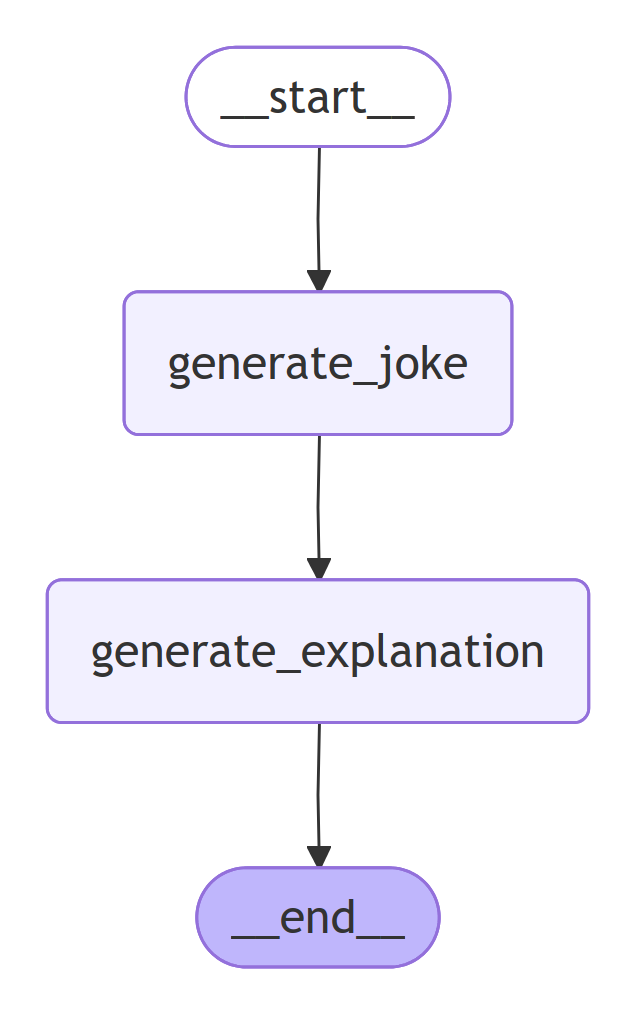

In [10]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

# 8. Incorporate the thread in config
To incorporate persistence, we are required to mention threads for each conversation, so that two different conversations do not pollute each other.

In [11]:
config1 = {"configurable": {"thread_id": "1"}}

In [12]:
config2 = {"configurable": {"thread_id": "2"}}

## 9. Run the code

In [13]:
# First Thread
final_state = workflow.invoke({'topic':'pizza'}, config=config1)
print(final_state)

{'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'Here\'s an explanation of the joke:\n\nThis is a play on words, using puns to create humor. The joke starts by setting up a question about why the pizza is in a "bad mood." Then, instead of giving a serious answer, it subverts expectations with a clever and silly response: that the pizza was feeling "crusty."\n\nHere\'s where the wordplay comes in:\n\n* In everyday language, "feeling crusty" can mean being in a bad mood or having a grumpy attitude.\n* However, for a pizza, "crusty" has a different meaning. A pizza\'s crust is its outer layer of dough that\'s been baked until crispy and golden brown.\n\nSo, the joke is making a connection between the two meanings of "crusty," using wordplay to create a clever pun. The punchline is funny because it takes an ordinary phrase ("feeling crusty") and gives it a new twist by applying it to a pizza, where it 

In [ ]:
# Second Thread
final_state = workflow.invoke({'topic':'pasta'}, config=config2)
print(final_state)

{'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?\n\nBecause it was feeling drained! (get it?)', 'explanation': 'A play on words!\n\nThe joke relies on a pun, using the phrase "feeling drained" in two different ways:\n\n1. **Literally**: As a long, thin pasta shape, spaghetti is made up of many strands that are connected at one end (the point where they\'re "drained"). So, when the spaghetti "goes to therapy," it\'s being treated for a problem related to its physical state.\n2. **Figuratively**: "Feeling drained" is also an idiomatic expression meaning feeling exhausted or depleted of energy and vitality. This is a common way people describe their emotional state when they\'re stressed, anxious, or overwhelmed.\n\nThe humor comes from the unexpected twist on the phrase\'s dual meanings, creating a clever play on words that connects the physical aspect of spaghetti (being "drained") with its potential emotional state (feeling drained).'}


In [15]:
print(final_state)

{'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?\n\nBecause it was feeling drained! (get it?)', 'explanation': 'A play on words!\n\nThe joke relies on a pun, using the phrase "feeling drained" in two different ways:\n\n1. **Literally**: As a long, thin pasta shape, spaghetti is made up of many strands that are connected at one end (the point where they\'re "drained"). So, when the spaghetti "goes to therapy," it\'s being treated for a problem related to its physical state.\n2. **Figuratively**: "Feeling drained" is also an idiomatic expression meaning feeling exhausted or depleted of energy and vitality. This is a common way people describe their emotional state when they\'re stressed, anxious, or overwhelmed.\n\nThe humor comes from the unexpected twist on the phrase\'s dual meanings, creating a clever play on words that connects the physical aspect of spaghetti (being "drained") with its potential emotional state (feeling drained).'}


In [16]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'Here\'s an explanation of the joke:\n\nThis is a play on words, using puns to create humor. The joke starts by setting up a question about why the pizza is in a "bad mood." Then, instead of giving a serious answer, it subverts expectations with a clever and silly response: that the pizza was feeling "crusty."\n\nHere\'s where the wordplay comes in:\n\n* In everyday language, "feeling crusty" can mean being in a bad mood or having a grumpy attitude.\n* However, for a pizza, "crusty" has a different meaning. A pizza\'s crust is its outer layer of dough that\'s been baked until crispy and golden brown.\n\nSo, the joke is making a connection between the two meanings of "crusty," using wordplay to create a clever pun. The punchline is funny because it takes an ordinary phrase ("feeling crusty") and gives it a new twist by applying it 

In [17]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?\n\nBecause it was feeling drained! (get it?)', 'explanation': 'A play on words!\n\nThe joke relies on a pun, using the phrase "feeling drained" in two different ways:\n\n1. **Literally**: As a long, thin pasta shape, spaghetti is made up of many strands that are connected at one end (the point where they\'re "drained"). So, when the spaghetti "goes to therapy," it\'s being treated for a problem related to its physical state.\n2. **Figuratively**: "Feeling drained" is also an idiomatic expression meaning feeling exhausted or depleted of energy and vitality. This is a common way people describe their emotional state when they\'re stressed, anxious, or overwhelmed.\n\nThe humor comes from the unexpected twist on the phrase\'s dual meanings, creating a clever play on words that connects the physical aspect of spaghetti (being "drained") with its potential emotional state (feeling drained).'}, next=(), con

# 10. Checking the checkpoint status

In [18]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'Here\'s an explanation of the joke:\n\nThis is a play on words, using puns to create humor. The joke starts by setting up a question about why the pizza is in a "bad mood." Then, instead of giving a serious answer, it subverts expectations with a clever and silly response: that the pizza was feeling "crusty."\n\nHere\'s where the wordplay comes in:\n\n* In everyday language, "feeling crusty" can mean being in a bad mood or having a grumpy attitude.\n* However, for a pizza, "crusty" has a different meaning. A pizza\'s crust is its outer layer of dough that\'s been baked until crispy and golden brown.\n\nSo, the joke is making a connection between the two meanings of "crusty," using wordplay to create a clever pun. The punchline is funny because it takes an ordinary phrase ("feeling crusty") and gives it a new twist by applying it

In [19]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?\n\nBecause it was feeling drained! (get it?)', 'explanation': 'A play on words!\n\nThe joke relies on a pun, using the phrase "feeling drained" in two different ways:\n\n1. **Literally**: As a long, thin pasta shape, spaghetti is made up of many strands that are connected at one end (the point where they\'re "drained"). So, when the spaghetti "goes to therapy," it\'s being treated for a problem related to its physical state.\n2. **Figuratively**: "Feeling drained" is also an idiomatic expression meaning feeling exhausted or depleted of energy and vitality. This is a common way people describe their emotional state when they\'re stressed, anxious, or overwhelmed.\n\nThe humor comes from the unexpected twist on the phrase\'s dual meanings, creating a clever play on words that connects the physical aspect of spaghetti (being "drained") with its potential emotional state (feeling drained).'}, next=(), co